In [2]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.9 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

<ipython-input-3-2d8da9a7586d>:54: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/100 [00:00<?, ?it/s]

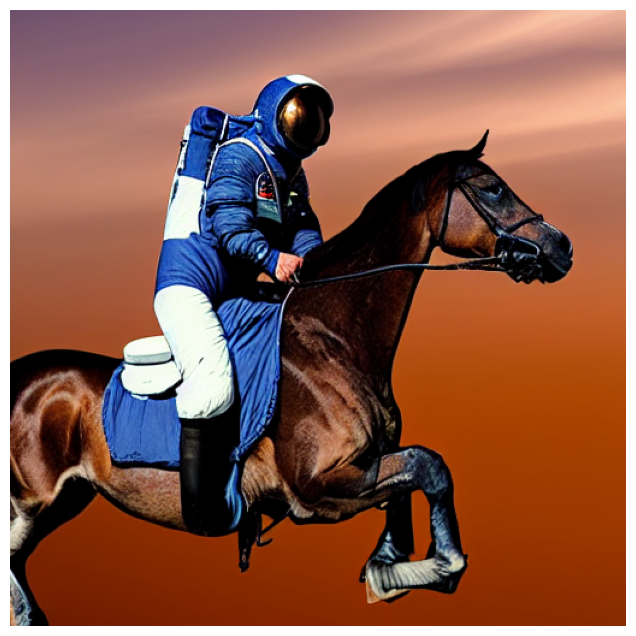

In [3]:

import torch
from diffusers import LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
import matplotlib.pyplot as plt
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]


text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

latents.shape

scheduler.set_timesteps(num_inference_steps)

latents = latents * scheduler.init_noise_sigma



for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample
  # scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample


image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
plt.figure(figsize=(8, 8))
plt.imshow(pil_images[0])
plt.axis('off')  # Turn off axis labels
plt.show()



<ipython-input-4-6a97bb88f7c8>:30: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/100 [00:00<?, ?it/s]

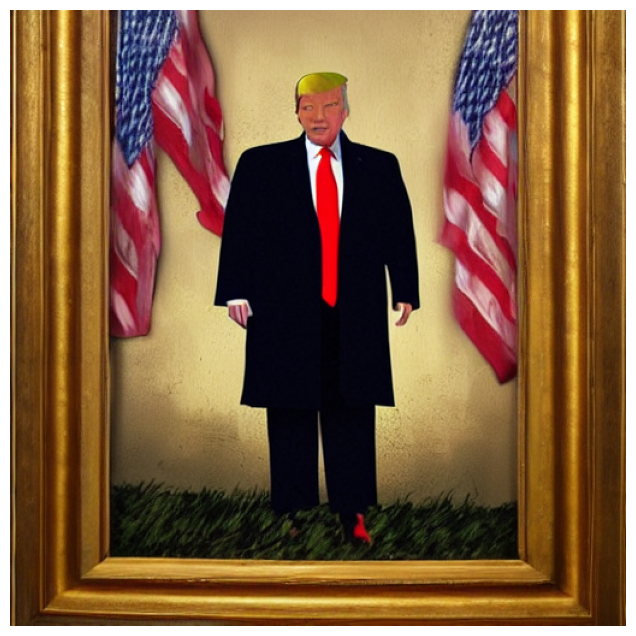

In [4]:
prompt = ["a art picture of donald trump"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]


text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

latents.shape

scheduler.set_timesteps(num_inference_steps)

latents = latents * scheduler.init_noise_sigma



for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample
  # scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample


image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
plt.figure(figsize=(8, 8))
plt.imshow(pil_images[0])
plt.axis('off')  # Turn off axis labels
plt.show()